In [1]:
import os
import pickle
from itertools import product
import logging
import copy
import random

import librosa
import numpy as np
from torch.utils.data import Dataset
import networkx as nx
from tqdm import tqdm
from scipy.io import wavfile
from scipy.signal import fftconvolve
from skimage.measure import block_reduce

from ss_baselines.common.utils import to_tensor
from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING



Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
2025-12-18 21:32:24.399299: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 21:32:24.434722: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 21:32:25.27

In [71]:
import os
import torch
import numpy as np

from soundspaces.utils import load_metadata
from ss_baselines.savi.pretraining_ours.audiogoal_predictor import AudioGoalPredictor
from ss_baselines.savi.pretraining_ours.audiogoal_dataset import AudioGoalDataset
from ss_baselines.savi.config.default import get_config
from soundspaces.mp3d_utils import SCENE_SPLITS

# -----------------------
# 1) 基本配置（你按需改）
# -----------------------
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CONFIG_PATH = "/home/Disk/sound-space/ss_baselines/savi/config/semantic_audionav/savi.yaml"
SPLIT = "val"                 # "train" / "val" / "test"
USE_CACHE = True             # 建议 inference 时 False，避免占用巨大内存
           # 你要看的 dataset index
PREDICT_LABEL = False
PREDICT_LOCATION = True

# 可选：加载 ckpt（设为 None 就不加载）
CKPT_PATH = "/home/Disk/yyz/sound-spaces/weights/savi_ours2/ckpt.19.pth"   # or None


# -----------------------
# 2) 构建 config / dataset
# -----------------------
config = get_config(config_paths=CONFIG_PATH, opts=None, run_type=None)
meta_dir = config.TASK_CONFIG.SIMULATOR.AUDIO.METADATA_DIR

scenes = SCENE_SPLITS[SPLIT]

scene_graphs = {}
for scene in scenes:
    points, graph = load_metadata(os.path.join(meta_dir, "mp3d", scene))
    scene_graphs[scene] = graph

dataset = AudioGoalDataset(
    scene_graphs=scene_graphs,
    scenes=scenes,
    split=SPLIT,
    use_polar_coordinates=True,
    use_cache=USE_CACHE,
)

print(f"[INFO] dataset split={SPLIT}, len={len(dataset)}")


# -----------------------
# 3) 构建模型 + 可选加载权重
# -----------------------
model = AudioGoalPredictor(
    predict_label=PREDICT_LABEL,
    predict_location=PREDICT_LOCATION
).to(DEVICE)
model.eval()

if CKPT_PATH is not None and os.path.exists(CKPT_PATH):
    ckpt = torch.load(CKPT_PATH, map_location="cpu")
    # 你的 trainer 存的是 {"audiogoal_predictor": state_dict}
    if "audiogoal_predictor" in ckpt:
        model.load_state_dict(ckpt["audiogoal_predictor"], strict=True)
        print(f"[INFO] loaded ckpt: {CKPT_PATH}")
    else:
        # 万一你保存的是裸 state_dict
        model.load_state_dict(ckpt, strict=True)
        print(f"[INFO] loaded ckpt (raw state_dict): {CKPT_PATH}")
else:
    print("[WARN] ckpt not loaded (path is None or not exists).")




[AudioGoalDataset] Load cache: /home/Disk/yyz/sound-spaces/cache/mp3d_val_pairs25000_polar1.npz
[INFO] dataset split=val, len=42452
[INFO] loaded ckpt: /home/Disk/yyz/sound-spaces/weights/savi_ours2/ckpt.19.pth


N goals: 42452
dist min/max/mean/std: 1.000 / 41.077 / 8.268 / 6.098

Bin stats:
[ 1.0,  2.0) m :   1900  ( 5.09%)
[ 2.0,  3.0) m :   3059  ( 8.19%)
[ 3.0,  4.0) m :   4760  (12.75%)
[ 4.0,  5.0) m :   4140  (11.09%)
[ 5.0,  6.0) m :   4631  (12.40%)
[ 6.0,  7.0) m :   3956  (10.59%)
[ 7.0,  8.0) m :   3556  ( 9.52%)
[ 8.0,  9.0) m :   3296  ( 8.83%)
[ 9.0, 10.0) m :   2397  ( 6.42%)
[10.0, 11.0) m :   1866  ( 5.00%)
[11.0, 12.0) m :   1277  ( 3.42%)
[12.0, 13.0) m :   1021  ( 2.73%)
[13.0, 14.0) m :    831  ( 2.23%)
[14.0, 15.0) m :    657  ( 1.76%)

Max/Min bin count ratio: 7.245053272450533

Label distribution (top 20):
label   5: 2143
label   0: 2081
label   4: 2072
label   3: 2047
label  13: 2042
label   2: 2032
label  11: 2027
label  15: 2025
label   7: 2025
label  12: 2019
label  10: 2011
label   6: 2011
label   1: 2011
label   8: 2006
label  20: 2006
label  19: 2001
label   9: 1999
label  16: 1998
label  14: 1988
label  18: 1975


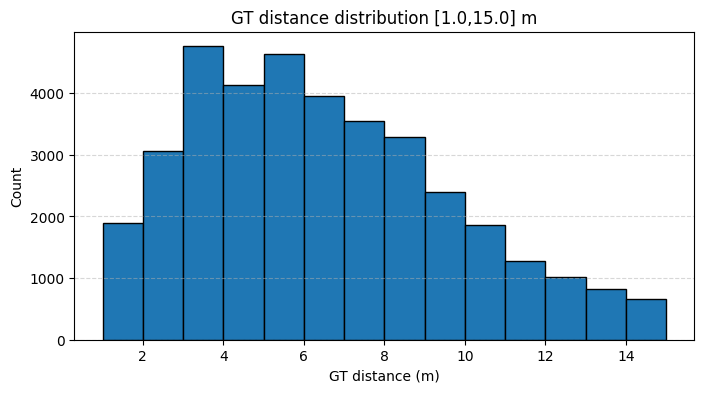

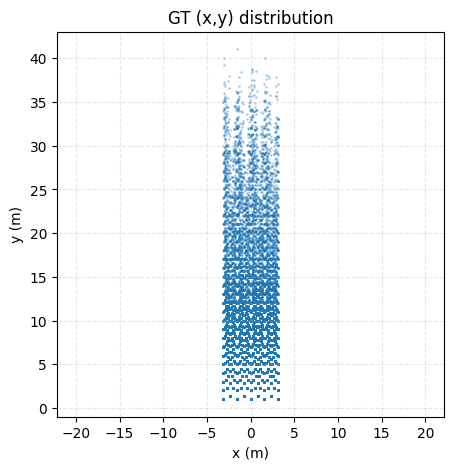

In [72]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def goals_to_numpy(goals):
    # goals: list[Tensor(3,)] or list[np.array]
    if len(goals) == 0:
        return np.zeros((0, 3), dtype=np.float32)
    if torch.is_tensor(goals[0]):
        g = torch.stack(goals, dim=0).cpu().numpy()  # (N,3)
    else:
        g = np.asarray(goals, dtype=np.float32)
    return g

def stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True):
    g = goals_to_numpy(dataset.goals)   # (N,3) -> [label, x, y]
    labels = g[:, 0].astype(np.int64)
    xs = g[:, 1]
    ys = g[:, 2]
    dists = np.sqrt(xs*xs + ys*ys)

    print(f"N goals: {len(dists)}")
    if len(dists) > 0:
        print(f"dist min/max/mean/std: {dists.min():.3f} / {dists.max():.3f} / {dists.mean():.3f} / {dists.std():.3f}")

    # 分桶统计
    edges = np.linspace(dist_min, dist_max, num_bins + 1)
    counts, _ = np.histogram(dists, bins=edges)

    total = counts.sum()
    print("\nBin stats:")
    for i in range(num_bins):
        lo, hi = edges[i], edges[i+1]
        ratio = counts[i] / total if total > 0 else 0
        print(f"[{lo:4.1f}, {hi:4.1f}) m : {counts[i]:6d}  ({ratio*100:5.2f}%)")
    if total > 0:
        print("\nMax/Min bin count ratio:", counts.max() / max(counts.min(), 1))

    # label 分布（可选）
    uniq, cnt = np.unique(labels, return_counts=True)
    print("\nLabel distribution (top 20):")
    order = np.argsort(-cnt)
    for u, c in list(zip(uniq[order], cnt[order]))[:20]:
        print(f"label {u:3d}: {c}")

    if plot and len(dists) > 0:
        plt.figure(figsize=(8,4))
        plt.hist(dists, bins=edges, edgecolor="black")
        plt.xlabel("GT distance (m)")
        plt.ylabel("Count")
        plt.title(f"GT distance distribution [{dist_min},{dist_max}] m")
        plt.grid(True, axis="y", linestyle="--", alpha=0.5)
        plt.show()

        # (x,y) scatter 看方向覆盖
        plt.figure(figsize=(5,5))
        plt.scatter(xs, ys, s=1, alpha=0.25)
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.axis("equal")
        plt.title("GT (x,y) distribution")
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.show()

    return dists, counts, edges

# 用法
dists, counts, edges = stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True)


In [76]:
# -----------------------
# 4) 取一个 sample，跑一次 forward
# -----------------------
# for SAMPLE_INDEX in range(100,200):
SAMPLE_INDEX = 2390  
(inputs_list, gt) = dataset[SAMPLE_INDEX]      # inputs_list = [spectrogram], gt shape (3,)
spectrogram = inputs_list[0]                  # torch tensor, shape (2, 65, 26)
gt_doa, gt_dis = gt
# 加 batch 维度 -> (1, 2, 65, 26)
x = spectrogram.unsqueeze(0).to(DEVICE, dtype=torch.float32)

with torch.no_grad():
    pred_doa,pred_dis = model({"spectrogram": x})          # shape: (1, C) or (1, C+2) or (1,2)
    pred_doa = pred_doa.squeeze(0).cpu()
    pred_dis = pred_dis.squeeze(0).cpu()
    
gt_doa_np = gt_doa.cpu().numpy() if torch.is_tensor(gt_doa) else np.array(gt_doa)
gt_dis_np = gt_dis.cpu().numpy() if torch.is_tensor(gt_dis) else np.array(gt_dis)    
print("========== SAMPLE ==========")
print("Index:", SAMPLE_INDEX)
print("\n========== GT ==========")
# gt[0] 是 label index；gt[1:] 是 (x,y)
print("GT doa label:", int(np.argmax(gt_doa_np)))
print("pred doa   :", np.argmax(pred_doa))
print("GT dis label:", int(np.argmax(gt_dis)))
print("pred dis   :", np.argmax(pred_dis))

========== SAMPLE ==========
Index: 2390

========== GT ==========
GT doa label: 21
pred doa   : tensor(26)
GT dis label: 34
pred dis   : tensor(32)


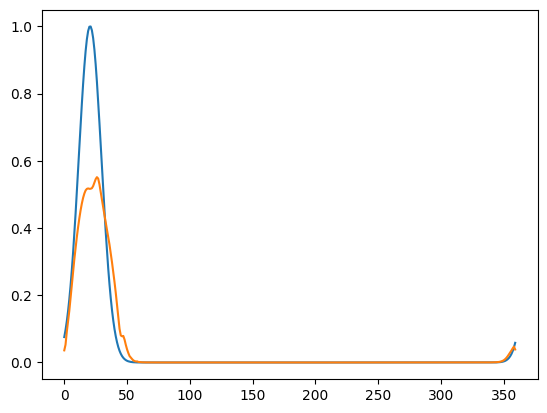

In [77]:
plt.plot(gt_doa_np)
plt.plot(pred_doa)

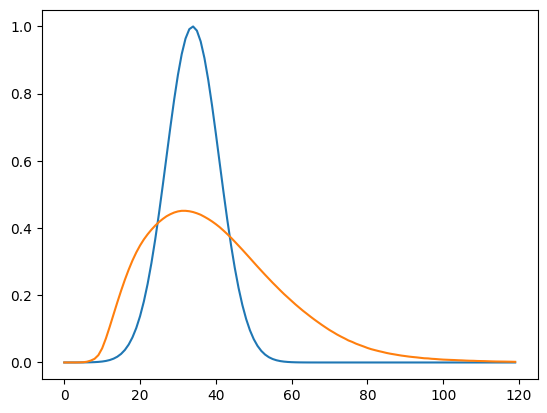

In [78]:
plt.plot(gt_dis_np)
plt.plot(pred_dis)

In [79]:
dataset.goals[SAMPLE_INDEX]

tensor([8.0000, 0.3588, 8.5440])